In [1]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [3]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [4]:
files = glob('Cappello/Cinnabar_Hydrocerussite/roi*.dat')
cnb_hcs = MixPhase([cinnabar,hydrocerussite])

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(1).snip()
    
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(cnb_hcs,spectra)]

N mixtures: 3
[-1218.28161894    51.66346478  1956.38101634]
[-1215.54344705    51.66346478  1954.66696833]
[-1212.96026533    51.66346478  1951.74673397]


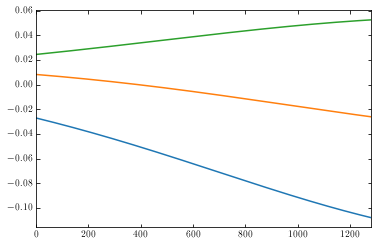

In [5]:
all_cinnabar = database['Cinnabar']
all_hydrocerussite = database['Hydrocerussite']
sb = []
for cinnabar in all_cinnabar:
    for hydrocerussite in all_hydrocerussite:
        sb += [MixPhase([cinnabar,hydrocerussite])]
print('N mixtures:',len(sb))

x = arange(1280)
gn = []
for phase in sb:
    gn += [GaussNewton(phase,xrd_spectra[0])]
    
for g in gn[:]:
    for _ in range(64):
        g.calibration(alpha=1)
        g.opt = g.spectra.opt.copy()
    print(g.spectra.opt)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

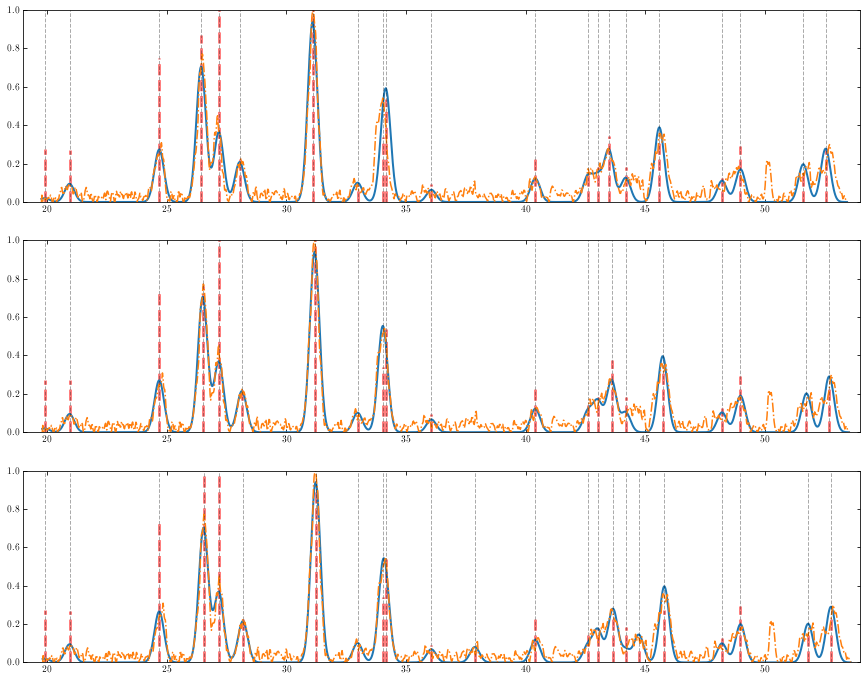

In [6]:
%matplotlib inline
fig,ax = subplots(3,1,figsize = (15,12))

for i,g in enumerate(gn[:]):
    
    g.spectra.opt = g.opt.copy()
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(g.spectra.theta,g.spectra.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[0.70070533 0.90828318 1.03935923 1.30856923 1.1901385  1.66920603
 1.44745943 1.38286158 1.27422256 0.07145542 0.34943761 0.35518949
 0.36460244 1.16440709 1.12152618 0.35311003 0.73974579 0.48537684
 0.57906108 0.91444039 0.35968089 0.78484172 0.6811553 ]


(19.0, 53.0)

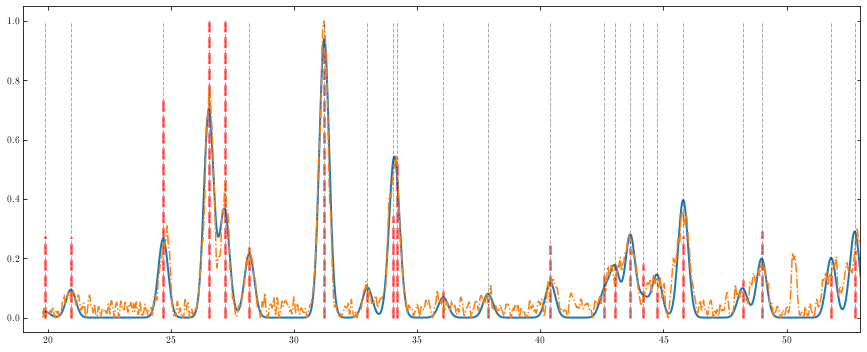

In [7]:
g = xrd_gn[0]
s = xrd_spectra[0]

for _ in range(32):
    g.calibration(alpha=1)  
print(g.gamma)

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(g.spectra.theta,g.spectra.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

xlim(19,53)
#ylim(0,1)

[-1212.96026533    51.66346478  1951.74673397]
[-1199.57085693    51.66346478  1942.88816522]
[-1211.49998583    51.66346478  1946.19631916]
[-1202.74047414    51.66346478  1949.31184284]
[-1201.73255977    51.66346478  1944.39835378]
[-1206.42807347    51.66346478  1942.23943527]
[-1196.28251367    51.66346478  1938.46267497]
[-1195.93217028    51.66346478  1936.74117824]


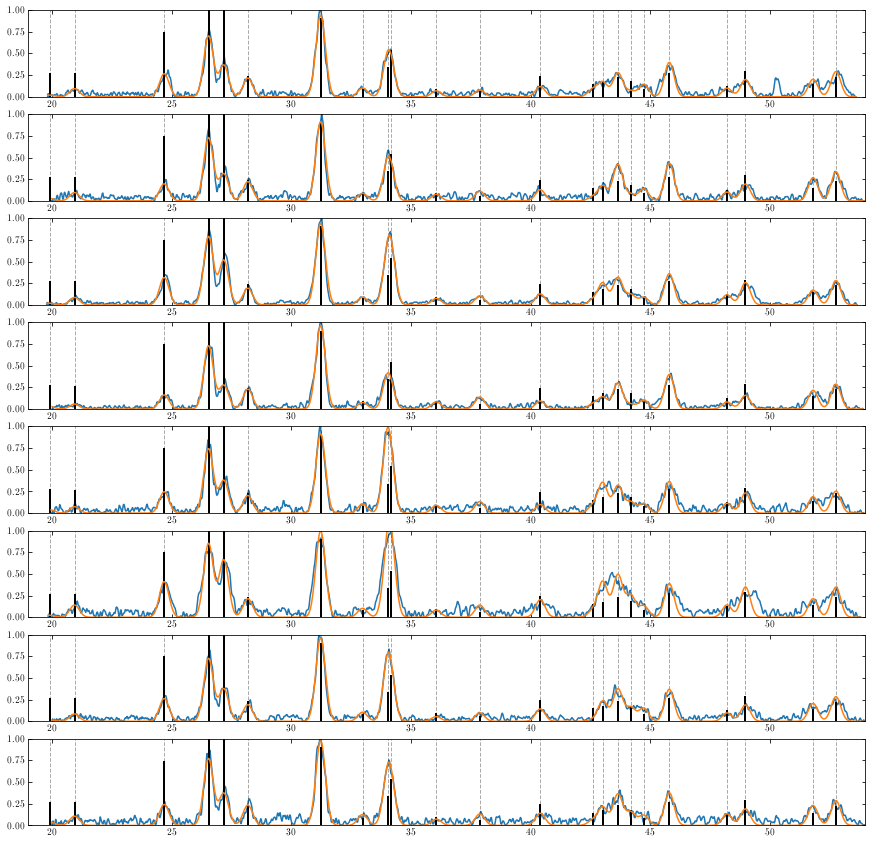

In [8]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(16):
        gn.calibration(alpha=0.5)
    print(gn.spectra.opt)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.05)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1212.96026533    51.66346478  1951.74673397] 9.758733669871367
[-1199.57085693    51.66346478  1942.88816522] 9.7144408260798
[-1211.49998583    51.66346478  1946.19631916] 9.730981595788386
[-1202.74047414    51.66346478  1949.31184284] 9.746559214209027
[-1201.73255977    51.66346478  1944.39835378] 9.721991768902454
[-1206.42807347    51.66346478  1942.23943527] 9.71119717637117
[-1196.28251367    51.66346478  1938.46267497] 9.69231337484037
[-1195.93217028    51.66346478  1936.74117824] 9.683705891214775


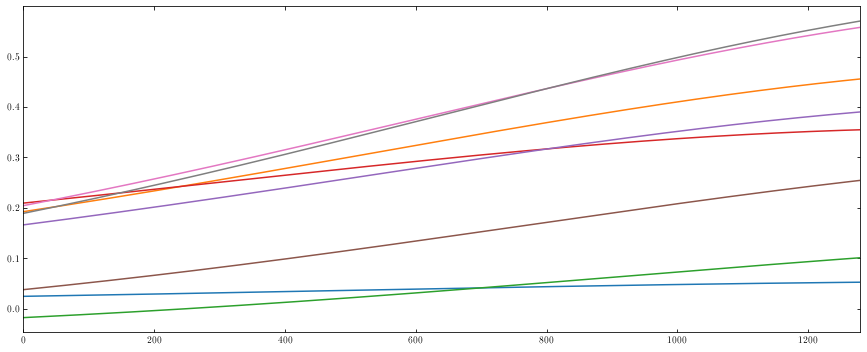

In [12]:
#fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    #print(opt,opt_file,opt[2]*5e-3)
    print(opt,opt[2]*5e-3)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)
